# Chapter 6

In [55]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import daft

from scipy import stats
from scipy.optimize import curve_fit
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

## Code 6.1

In [4]:
np.random.seed(3)
N = 200
p = 0.1

In [5]:
nw = np.random.normal(size = N)
tw = np.random.normal(size = N)

In [6]:
s = nw + tw

In [7]:
q = np.quantile(s, 1 - p)

In [8]:
selected = s >= q

In [9]:
cor = np.corrcoef(tw[selected], nw[selected])

In [10]:
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

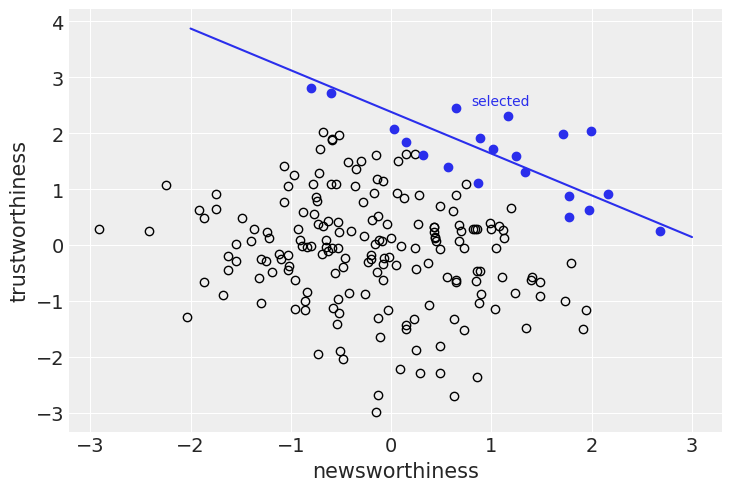

In [11]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

## Code 6.8

In [12]:
d = pd.read_csv(
    'C:/Users/bacos1/Documents/Python/per_python_bayes/Statistical_Rethinking/data/milk.csv',
    sep = ';'
)

In [13]:
d = (d
     .assign(
         K = lambda x: stats.zscore(x['kcal.per.g']),
         F = lambda x: stats.zscore(x['perc.fat']),
         L = lambda x: stats.zscore(x['perc.lactose']) 
    )    
)

In [14]:
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.956680,-1.238788,1.330401
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.830572,-1.048593,1.029186
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.145842,-1.416162,1.407153
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.019734,-1.359174,1.614963
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.263087,-0.478006,0.261666


## Code 6.9

In [15]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = a + bF * d.F.values
   
    K = pm.Normal("K", mu, sigma, observed=d.K.values)

In [16]:
with m_6_3:
    m_6_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [17]:
az.summary(m_6_3_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.14,0.13,0.0,0.0,4034.78,2968.54,1.0
bF,0.86,0.09,0.72,1.01,0.0,0.0,4558.92,3043.00,1.0
sigma,0.50,0.07,0.39,0.60,0.0,0.0,5559.67,3051.35,1.0


In [18]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = a + bL * d.L.values    

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

In [19]:
with m_6_4:
    m_6_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [20]:
az.summary(m_6_4_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.07,-0.11,0.12,0.0,0.0,4335.14,2931.66,1.0
bF,-0.90,0.08,-1.03,-0.78,0.0,0.0,4689.84,2316.74,1.0
sigma,0.42,0.06,0.33,0.52,0.0,0.0,3618.75,2372.00,1.0


## Code 6.10

In [21]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F.values + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

In [22]:
with m_6_5:
    m_6_5_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [23]:
az.summary(m_6_5_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.13,0.0,0.0,3045.03,2366.76,1.0
bF,0.25,0.19,-0.04,0.58,0.0,0.0,1633.10,2232.81,1.0
bL,-0.67,0.19,-0.96,-0.36,0.0,0.0,1621.16,2229.30,1.0
sigma,0.42,0.06,0.33,0.51,0.0,0.0,2652.31,1995.19,1.0


## Code 6.11

C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


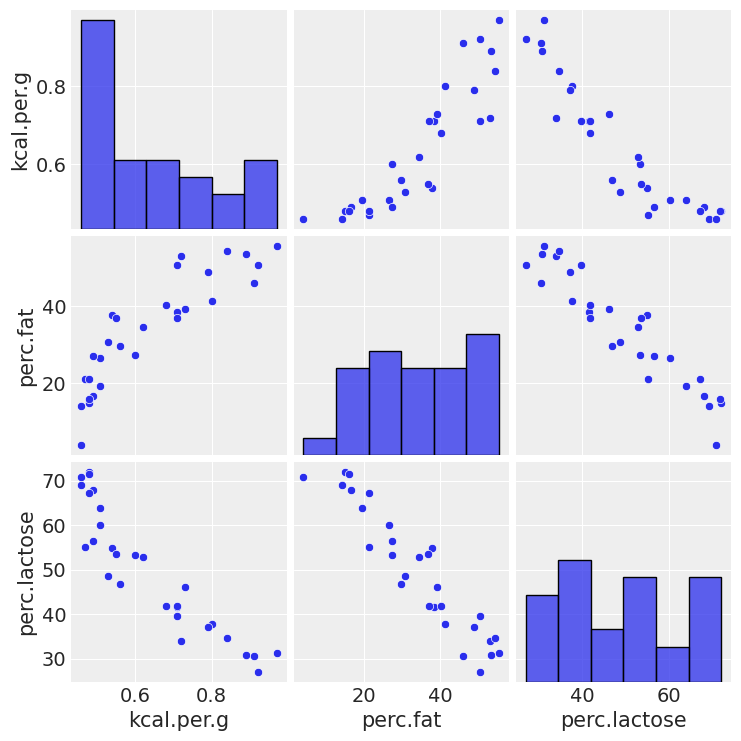

In [24]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

## 6.13

In [19]:
N = 100

h0 = np.random.normal(10, 2, N)

In [20]:
treatment = np.repeat([0, 1], N / 2)

In [21]:
fungus = np.random.binomial(n = 1, p = 0.5 - 0.4*treatment, size = N)

In [22]:
h1 = h0 + np.random.normal(5 - 3 * fungus, size = N)

In [23]:
d = pd.DataFrame.from_dict(
    {
        'h0': h0,
        'h1': h1,
        'treatment': treatment,
        'fungus': fungus
    }
)

In [24]:
az.summary(d
           .to_dict(orient = 'list'),
           kind = 'stats',
           round_to = 2    
)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.09,2.02,7.65,13.78
h1,14.48,2.36,11.49,18.48
treatment,0.50,0.50,0.00,1.00
fungus,0.22,0.42,0.00,1.00


## 6.14

In [25]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

In [26]:
az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.63,1.41


# 6.15

In [37]:
with pm.Model() as m_6_6:

    # Data setup
    x_data = pm.Data('x_data', d.h0.values, mutable = True)
    y_data = pm.Data('y_data', d.h1.values, mutable = True)
    
    # Prior
    p = pm.Lognormal('p', 0, 0.25)
    sigma = pm.Exponential('sigma', 1)

    # Model
    mu = p*x_data

    # Likelyhood
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed = y_data)

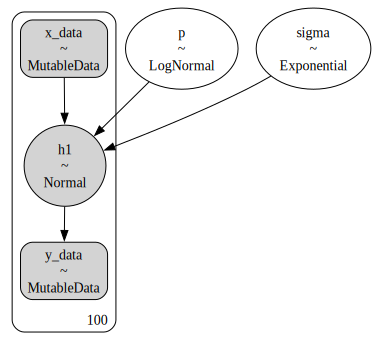

In [38]:
pm.model_to_graphviz(m_6_6)

In [39]:
with m_6_6:
    m_6_6_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


In [40]:
az.summary(m_6_6_trace, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.41,0.02,1.39,1.44,0.0,0.0,4076.81,3057.29,1.0
sigma,1.77,0.13,1.57,1.98,0.0,0.0,4293.12,2774.23,1.0


## Code 6.16

In [44]:
with pm.Model() as m_6_7:
    
    # Data
    treat = pm.Data('treat', d.treatment.values, mutable = True)
    fungus = pm.Data('fungus', d.fungus.values, mutable = True)
    h0 = pm.Data('h0', d.h0.values, mutable = True)

    # Prior
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # Model
    p = a + bt*treat + bf*fungus
    mu = p*h0

    # Likelihood
    h1 = pm.Normal("h1", mu = mu, sigma = sigma, observed = h1)

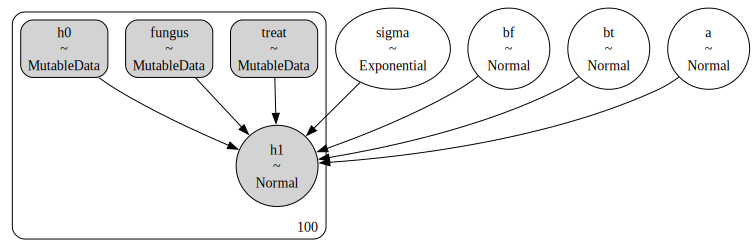

In [45]:
pm.model_to_graphviz(m_6_7)

In [47]:
with m_6_7:
    m_6_7_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


In [48]:
az.summary(m_6_7_trace, round_to = 2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.46,0.02,1.43,1.50,0.0,0.0,2356.18,2281.29,1.0
bt,0.01,0.03,-0.04,0.06,0.0,0.0,2414.82,2563.77,1.0
bf,-0.24,0.03,-0.30,-0.19,0.0,0.0,2753.13,2916.66,1.0
sigma,1.40,0.10,1.25,1.56,0.0,0.0,3069.41,2584.87,1.0


## 6.17

In [50]:
with pm.Model() as m_6_8:
    
    # Data
    treat = pm.Data('treat', d.treatment.values, mutable = True)
    #fungus = pm.Data('fungus', d.fungus.values, mutable = True)
    h0 = pm.Data('h0', d.h0.values, mutable = True)
    y_data = pm.Data('y_data', d.h1.values, mutable = True)

    # Prior
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    #bf = pm.Normal("bf", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # Model
    p = a + bt*treat
    mu = p*h0

    # Likelihood
    h1 = pm.Normal("h1", mu = mu, sigma = sigma, observed = y_data)

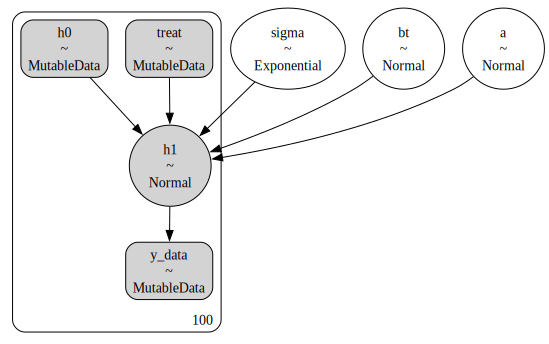

In [51]:
pm.model_to_graphviz( m_6_8)

In [53]:
with m_6_8:
    m_6_8_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


In [54]:
az.summary(m_6_8_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.371,0.024,1.333,1.408,0.000,0.000,2604.0,2564.0,1.0
bt,0.073,0.034,0.018,0.127,0.001,0.000,2531.0,2892.0,1.0
sigma,1.762,0.126,1.561,1.958,0.002,0.002,2705.0,2499.0,1.0


## 6.18

In [56]:
def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()

In [57]:
plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}

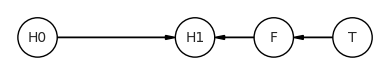

In [59]:
draw_dag(plant_dag, coordinates);

## 6.19

In [60]:
all_independencies = plant_dag.get_all_independence_relationships()

In [61]:
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
         print(s)

('T', 'H1', {'F'})
('T', 'H0', set())
('F', 'H0', set())
